In [1]:
# Import Modules #
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score

# AUC plot functions

In [2]:
def bootstrap_results(y_truth, y_pred,num_bootstraps = 1000):
    n_bootstraps = num_bootstraps
    rng_seed = 42  # control reproducibility
    y_pred=y_pred
    y_true=y_truth
    rng = np.random.RandomState(rng_seed)
    tprs=[]
    fprs=[]
    aucs=[]
    threshs=[]
    base_thresh = np.linspace(0, 1, 101)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            continue
        fpr, tpr, thresh = metrics.roc_curve(y_true[indices],y_pred[indices])
        thresh=thresh[1:]
        thresh=np.append(thresh,[0.0])
        thresh=thresh[::-1]
        fpr = np.interp(base_thresh, thresh, fpr[::-1])
        tpr = np.interp(base_thresh, thresh, tpr[::-1])
        tprs.append(tpr)
        fprs.append(fpr)
        threshs.append(thresh)
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)  
    fprs = np.array(fprs)
    mean_fprs = fprs.mean(axis=0)
    
    return base_thresh, mean_tprs, mean_fprs

In [3]:
def get_auc_ci(y_truth, y_pred,num_bootstraps = 1000):
    n_bootstraps = num_bootstraps
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []
    y_pred=y_pred
    y_true=y_truth
    rng = np.random.RandomState(rng_seed)
    tprs=[]
    aucs=[]
    base_fpr = np.linspace(0, 1, 101)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
        fpr, tpr, _ = metrics.roc_curve(y_true[indices],y_pred[indices])
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)
    mean_auc = metrics.auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)
    tprs_upper = np.minimum(mean_tprs + std*2, 1)
    tprs_lower = mean_tprs - std*2
    return base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc

def plot_auc(truth, reference_model, new_model,n_bootstraps=1000, save=False):
    y_truth = truth
    ref_model = reference_model
    new_model = new_model
    ref_fpr, ref_tpr, ref_thresholds = metrics.roc_curve(y_truth, ref_model)
    new_fpr, new_tpr, new_thresholds = metrics.roc_curve(y_truth, new_model)
    ref_auc, new_auc = metrics.auc(ref_fpr, ref_tpr), metrics.auc(new_fpr, new_tpr)
    print('ref auc =',ref_auc, '\nnew auc = ', new_auc)   
    base_fpr_ref, mean_tprs_ref, tprs_lower_ref, tprs_upper_ref, mean_auc_ref, std_auc_ref=get_auc_ci(y_truth, ref_model,n_bootstraps)
    base_fpr_new, mean_tprs_new, tprs_lower_new, tprs_upper_new, mean_auc_new, std_auc_new=get_auc_ci(y_truth, new_model,n_bootstraps)
    plt.figure(figsize=(8, 8))
    lw = 2
    plt.plot(ref_fpr, ref_tpr, color='blue',
             lw=lw, label='Reference raw ROC (AUC = %0.2f)' % ref_auc, linestyle='--')
    plt.plot(base_fpr_ref, mean_tprs_ref, 'b', alpha = 0.8, label=r'Reference mean ROC (AUC=%0.2f, CI=%0.2f-%0.2f)' % (mean_auc_ref, (mean_auc_ref-2*std_auc_ref),(mean_auc_ref+2*std_auc_ref)),)
    plt.fill_between(base_fpr_ref, tprs_lower_ref, tprs_upper_ref, color = 'b', alpha = 0.2)
    plt.plot(new_fpr, new_tpr, color='darkorange',
             lw=lw, label='New raw ROC (AUC = %0.2f)' % new_auc, linestyle='--')
    plt.plot(base_fpr_new, mean_tprs_new, 'darkorange', alpha = 0.8, label=r'New mean ROC (AUC=%0.2f, CI=%0.2f-%0.2f)' % (mean_auc_new,(mean_auc_new-2*std_auc_new),(mean_auc_new+2*std_auc_new)),)
    plt.fill_between(base_fpr_new, tprs_lower_new, tprs_upper_new, color = 'darkorange', alpha = 0.2)
    plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('1 - Specificity', fontsize=18)
    plt.ylabel('Sensitivity', fontsize=18)
    plt.legend(loc="lower right", fontsize=13)
    plt.gca().set_aspect('equal', adjustable='box')

# NRI functions

In [4]:
def check_cat(prob,thresholds):
    cat=0
    for i,v in enumerate(thresholds):
        if prob>v:
            cat=i
    return cat

def make_cat_matrix(ref, new, indices, thresholds):
    num_cats=len(thresholds)
    mat=np.zeros((num_cats,num_cats))
    for i in indices:
        row,col=check_cat(ref[i],thresholds),check_cat(new[i],thresholds)
        mat[row,col]+=1
    return mat
        
def nri(y_truth,y_ref, y_new,risk_thresholds):
    event_index = np.where(y_truth==1)[0]
    nonevent_index = np.where(y_truth==0)[0]
    event_mat=make_cat_matrix(y_ref,y_new,event_index,risk_thresholds)
    nonevent_mat=make_cat_matrix(y_ref,y_new,nonevent_index,risk_thresholds)
    events_up, events_down = event_mat[0,1:].sum()+event_mat[1,2:].sum()+event_mat[2,3:].sum(),event_mat[1,:1].sum()+event_mat[2,:2].sum()+event_mat[3,:3].sum()
    nonevents_up, nonevents_down = nonevent_mat[0,1:].sum()+nonevent_mat[1,2:].sum()+nonevent_mat[2,3:].sum(),nonevent_mat[1,:1].sum()+nonevent_mat[2,:2].sum()+nonevent_mat[3,:3].sum()
    nri_events = (events_up/len(event_index))-(events_down/len(event_index))
    nri_nonevents = (nonevents_down/len(nonevent_index))-(nonevents_up/len(nonevent_index))
    return nri_events, nri_nonevents, nri_events + nri_nonevents 


def track_movement(ref,new, indices):
    up, down = 0,0
    for i in indices:
        ref_val, new_val = ref[i],new[i]
        if ref_val<new_val:
            up+=1
        elif ref_val>new_val:
            down+=1
    return up, down

def category_free_nri(y_truth,y_ref, y_new):
    event_index = np.where(y_truth==1)[0]
    nonevent_index = np.where(y_truth==0)[0]
    events_up, events_down = track_movement(y_ref, y_new,event_index)
    nonevents_up, nonevents_down = track_movement(y_ref, y_new,nonevent_index)
    nri_events = (events_up/len(event_index))-(events_down/len(event_index))
    nri_nonevents = (nonevents_down/len(nonevent_index))-(nonevents_up/len(nonevent_index))
    return nri_events, nri_nonevents, nri_events + nri_nonevents 

# IDI plot functions

In [5]:
def area_between_curves(y1,y2):
    diff = y1 - y2 # calculate difference
    posPart = np.maximum(diff, 0) 
    negPart = -np.minimum(diff, 0) 
    posArea = np.trapz(posPart)
    negArea = np.trapz(negPart)
    return posArea,negArea,posArea-negArea

def plot_idi(y_truth, ref_model, new_model, save=False): 
    ref_fpr, ref_tpr, ref_thresholds = metrics.roc_curve(y_truth, ref_model)
    new_fpr, new_tpr, new_thresholds = metrics.roc_curve(y_truth, new_model)
    base, mean_tprs, mean_fprs=bootstrap_results( y_truth, new_model,100)
    base2, mean_tprs2, mean_fprs2=bootstrap_results( y_truth, ref_model,100)
    is_pos,is_neg, idi_event=area_between_curves(mean_tprs,mean_tprs2)
    ip_pos,ip_neg, idi_nonevent=area_between_curves(mean_fprs2,mean_fprs)
    print('IS positive', round(is_pos,2),'IS negative',round(is_neg,2),'IDI events',round(idi_event,2))
    print('IP positive', round(ip_pos,2),'IP negative',round(ip_neg,2),'IDI nonevents',round(idi_nonevent,2))
    print('IDI =',round(idi_event+idi_nonevent,2))
    plt.figure(figsize=(10, 10))
    ax=plt.axes()
    lw = 2
    plt.plot(base, mean_tprs, 'black', alpha = 0.5, label='Events New (New)' )
    plt.plot(base, mean_fprs, 'red', alpha = 0.5, label='Nonevents New (New)')
    plt.plot(base2, mean_tprs2, 'black', alpha = 0.7, linestyle='--',label='Events Reference (Ref)' )
    plt.plot(base2, mean_fprs2, 'red', alpha = 0.7,  linestyle='--', label='Nonevents Reference (Ref)')
    plt.fill_between(base, mean_tprs,mean_tprs2, color='black',alpha = 0.1, label='Integrated Sensitivity (area = %0.2f)'%idi_event)
    plt.fill_between(base, mean_fprs,mean_fprs2, color='red', alpha = 0.1, label='Integrated Specificity (area = %0.2f)'%idi_nonevent)
    
    #''' #TODO: comment out if not for breast birads
    ### BIRADS Thresholds ###
    plt.axvline(x=0.02,color='darkorange',linestyle='--',alpha=.5,label='BI-RADS 3/4a Border (2%)')
    plt.axvline(x=0.10,color='green',linestyle='--',alpha=.5,label='BI-RADS 4a/4b Border (10%)')
    plt.axvline(x=0.5,color='blue',linestyle='--',alpha=.5,label='BI-RADS 4b/4c Border (50%)')
    plt.axvline(x=0.95,color='purple',linestyle='--',alpha=.5,label='BI-RADS 4c/5 Border (95%)')
    def nri_annotation(plt, threshold):
        x_pos = base[threshold]
        x_offset=0.02
        x_offset2=x_offset
        text_y_offset=0.01
        text_y_offset2=text_y_offset
        if threshold==2:
            text_y_offset=0.04
            text_y_offset2=0.04
            x_offset2=0.05
            print(x_pos+x_offset, (np.mean([mean_tprs2[threshold], mean_tprs[threshold]])+text_y_offset),
                    x_pos, (np.mean([mean_tprs2[threshold], mean_tprs[threshold]])))
        text_y_events=np.mean([mean_tprs2[threshold], mean_tprs[threshold]])+text_y_offset
        text_y_nonevents=np.mean([mean_fprs[threshold], mean_fprs2[threshold]])+text_y_offset2
        plt.annotate('', xy=(x_pos+0.02, mean_tprs2[threshold+1]), xycoords='data', xytext=(x_pos+0.02, 
                            mean_tprs[threshold]), textcoords='data', arrowprops={'arrowstyle': '|-|'})
        plt.annotate('NRI$_{events}$ = %0.2f'%(mean_tprs[threshold]-mean_tprs2[threshold]), 
                     xy=(x_pos+x_offset, text_y_events), xycoords='data',
                     xytext=(x_pos+x_offset, text_y_events),
                     textcoords='offset points', fontsize=15)
        plt.annotate('', xy=(x_pos+0.02, mean_fprs[threshold]), xycoords='data', xytext=(x_pos+0.02, 
                             mean_fprs2[threshold]), textcoords='data', arrowprops=dict(arrowstyle= '|-|',color='r'))
        plt.annotate('NRI$_{nonevents}$ = %0.2f'%(mean_fprs2[threshold]-mean_fprs[threshold]), 
                     xy=(x_pos+x_offset2, text_y_nonevents), xycoords='data',
                     xytext=(x_pos+x_offset2, text_y_nonevents), 
                     textcoords='offset points', fontsize=15)
        print('Threshold =',round(x_pos,2),'NRI events =',round(mean_tprs[threshold]-mean_tprs2[threshold],4),
              'NRI nonevents =',round(mean_fprs2[threshold]-mean_fprs[threshold],4),'Total =',
              round((mean_tprs[threshold]-mean_tprs2[threshold])+(mean_fprs2[threshold]-mean_fprs[threshold]),4))
    nri_annotation(plt,2)
    nri_annotation(plt,10)
    nri_annotation(plt,50)
    nri_annotation(plt,95)
    #'''
    plt.xlim([0.0, 1.10])
    plt.ylim([0.0, 1.10])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel('Calculated Risk', fontsize=18)
    plt.ylabel('Sensitivity (black), 1 - Specificity (red)', fontsize=18)
    plt.legend(loc="upper right", fontsize=11)
    plt.legend(loc=0, fontsize=11,  bbox_to_anchor=(0,0,1.2,.9))
    plt.gca().set_aspect('equal', adjustable='box')
    #if save:
    #    plt.savefig('idi_curve.png',dpi=300, bbox_inches='tight')
    look=95
    plt.show()
#plot_idi(y_test.values,test_pred[:,1],test_pred2[:,1])

In [6]:
data = load_breast_cancer()

# IDI example

For the sake of an example:

Reference model contains only error features

New model contains errror features, plus worst and mean features

Therefore we are trying to see how the worst and mean features improve the model

In [7]:
df = pd.DataFrame(data=data['data'],columns=data['feature_names'])
df['label']=data['target']
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.40, random_state=123)
#x_val, x_test, y_val, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.50, random_state=123)

In [8]:
ref_feat, new_feat, bla = [],[], []
for i in data['feature_names']:
    if 'fractal' in i or 'smoothness' in i or 'texture' in i or 'concave' in i or 'compactness' in i:
        ref_feat+=[i]
    else:
        bla+=[i]
    new_feat+=[i]
len(ref_feat),len(new_feat)

(15, 30)

In [9]:
def get_auc_ci(y_truth, y_pred,num_bootstraps = 1000):
    n_bootstraps = num_bootstraps
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []
    y_pred=y_pred
    y_true=y_truth
    rng = np.random.RandomState(rng_seed)
    tprs=[]
    aucs=[]
    base_fpr = np.linspace(0, 1, 101)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
        fpr, tpr, _ = metrics.roc_curve(y_true[indices],y_pred[indices])
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)
    mean_auc = metrics.auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)
    tprs_upper = np.minimum(mean_tprs + std*2, 1)
    tprs_lower = mean_tprs - std*2
    return base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc

def plot_auc(truth, reference_model, new_model,n_bootstraps=1000, save=False):
    y_truth = truth
    ref_model = reference_model
    new_model = new_model
    ref_fpr, ref_tpr, ref_thresholds = metrics.roc_curve(y_truth, ref_model)
    new_fpr, new_tpr, new_thresholds = metrics.roc_curve(y_truth, new_model)
    ref_auc, new_auc = metrics.auc(ref_fpr, ref_tpr), metrics.auc(new_fpr, new_tpr)
    print('ref auc =',ref_auc, '\newn auc = ', new_auc)   
    base_fpr_ref, mean_tprs_ref, tprs_lower_ref, tprs_upper_ref, mean_auc_ref, std_auc_ref=get_auc_ci(y_truth, ref_model,n_bootstraps)
    base_fpr_new, mean_tprs_new, tprs_lower_new, tprs_upper_new, mean_auc_new, std_auc_new=get_auc_ci(y_truth, new_model,n_bootstraps)
    plt.figure(figsize=(8, 8))
    lw = 2
    plt.plot(ref_fpr, ref_tpr, color='blue',
             lw=lw, label='Reference raw ROC (AUC = %0.2f)' % ref_auc, linestyle='--')
    plt.plot(base_fpr_ref, mean_tprs_ref, 'b', alpha = 0.8, label=r'Reference mean ROC (AUC=%0.2f, CI=%0.2f-%0.2f)' % (mean_auc_ref, (mean_auc_ref-2*std_auc_ref),(mean_auc_ref+2*std_auc_ref)),)
    plt.fill_between(base_fpr_ref, tprs_lower_ref, tprs_upper_ref, color = 'b', alpha = 0.2)
    plt.plot(new_fpr, new_tpr, color='darkorange',
             lw=lw, label='New raw ROC (AUC = %0.2f)' % new_auc, linestyle='--')
    plt.plot(base_fpr_new, mean_tprs_new, 'darkorange', alpha = 0.8, label=r'New mean ROC (AUC=%0.2f, CI=%0.2f-%0.2f)' % (mean_auc_new,(mean_auc_new-2*std_auc_new),(mean_auc_new+2*std_auc_new)),)
    plt.fill_between(base_fpr_new, tprs_lower_new, tprs_upper_new, color = 'darkorange', alpha = 0.2)
    plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('1 - Specificity', fontsize=18)
    plt.ylabel('Sensitivity', fontsize=18)
    plt.legend(loc="lower right", fontsize=13)
    plt.gca().set_aspect('equal', adjustable='box')#feat_list = ['mean fractal dimension']



In [10]:
ref_model = RandomForestClassifier()#max_depth=5, n_estimators=100, verbose=1,random_state=0)
new_model = RandomForestClassifier()#max_depth=5, n_estimators=100, verbose=1,random_state=0)
ref_model.fit(x_train[ref_feat], y_train)
new_model.fit(x_train[new_feat], y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [11]:
test_ref_pred=ref_model.predict_proba(x_test[ref_feat])
test_new_pred=new_model.predict_proba(x_test[new_feat])

ref auc = 0.9875811688311688 
ewn auc =  0.9954139610389611


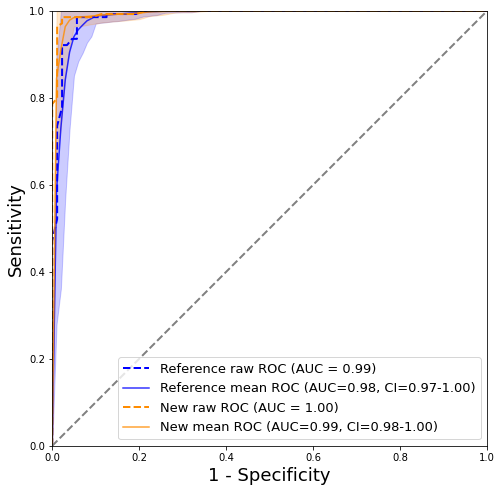

In [12]:
plot_auc(y_test.values,test_ref_pred[:,1],test_new_pred[:,1],n_bootstraps=100)

In [13]:
print(category_free_nri(y_test.values,test_ref_pred[:,1],test_new_pred[:,1]))

(0.46428571428571425, 0.5909090909090908, 1.055194805194805)


In [14]:
print(nri(y_test.values,test_ref_pred[:,1],test_new_pred[:,1],[0.02,0.1,0.5,0.95]))

(0.19285714285714287, 0.19318181818181818, 0.38603896103896107)


IS positive 4.07 IS negative 0.11 IDI events 3.96
IP positive 5.43 IP negative 0.0 IDI nonevents 5.43
IDI = 9.39
0.04 1.04 0.02 1.0
Threshold = 0.02 NRI events = 0.0 NRI nonevents = 0.3153 Total = 0.3153
Threshold = 0.1 NRI events = -0.0005 NRI nonevents = 0.1379 Total = 0.1374
Threshold = 0.5 NRI events = 0.0216 NRI nonevents = 0.035 Total = 0.0566
Threshold = 0.95 NRI events = 0.1764 NRI nonevents = 0.0135 Total = 0.19


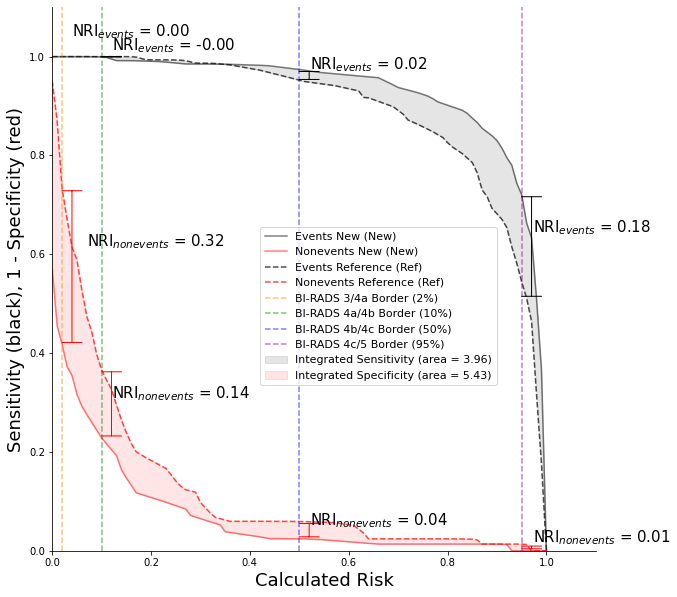

In [15]:
plot_idi(y_test.values,test_ref_pred[:,1],test_new_pred[:,1])